In [2]:
import requests
import pandas as pd

# Define your gene-disease mapping
gene_disease_map = {
    "LMNA": "Hutchinson-Gilford Progeria",
    "SMPD1": "Niemann-Pick Disease",
    "NPC1": "Niemann-Pick Disease",
    "CLN3": "Batten Disease",
    "CLN1": "Batten Disease",
    "CLN2": "Batten Disease",
    "ACVR1": "Fibrodysplasia Ossificans Progressiva",
    "MECP2": "Rett Syndrome"
}

# API endpoint for OpenTargets GraphQL
url = "https://api.platform.opentargets.org/api/v4/graphql"

# Query template for drug-gene interaction
query_template = """
query {{
  target(ensemblId: "{ensembl_id}") {{
    id
    approvedSymbol
    knownDrugs {{
      rows {{
        drug {{
          id
          name
        }}
        mechanismOfAction
        status
        phase
        disease {{
          name
        }}
      }}
    }}
  }}
}}
"""

# Function to get Ensembl gene ID from HGNC symbol using MyGene.info
def get_ensembl_id(symbol):
    response = requests.get(f"https://mygene.info/v3/query?q={symbol}&fields=ensembl.gene&species=human")
    try:
        hits = response.json().get('hits', [])
        for hit in hits:
            if 'ensembl' in hit:
                ensembl = hit['ensembl']
                return ensembl['gene'] if isinstance(ensembl, dict) else ensembl[0]['gene']
    except:
        return None

# Store results
results = []

# Main loop
for gene, disease in gene_disease_map.items():
    ensembl_id = get_ensembl_id(gene)
    if ensembl_id is None:
        print(f"❌ Could not find Ensembl ID for {gene}")
        continue

    # Format GraphQL query
    query = query_template.format(ensembl_id=ensembl_id)
    response = requests.post(url, json={"query": query})

    try:
        data = response.json()
        drug_data = data['data']['target']['knownDrugs']['rows']

        for d in drug_data:
            results.append({
                "Disease": disease,
                "Gene": gene,
                "Drug": d['drug']['name'],
                "Mechanism": d.get('mechanismOfAction', "N/A"),
                "Status": d.get('status', "N/A"),
                "Approval Phase": d.get('phase', "N/A"),
                "Indicated Disease": d['disease']['name'] if d.get('disease') else "N/A"
            })

    except Exception as e:
        print(f"⚠️ Error with {gene}: {e}")
        continue

# Create DataFrame and save
df = pd.DataFrame(results)
df.to_csv("open_targets_drug_gene_disease.csv", index=False)
print("✅ Data saved to open_targets_drug_gene_disease.csv")


✅ Data saved to open_targets_drug_gene_disease.csv


In [3]:
import pandas as pd

# Load the saved CSV
df = pd.read_csv("open_targets_drug_gene_disease.csv")

# Preview the first few rows
print(df.head(10))


                                 Disease   Gene             Drug  \
0  Fibrodysplasia Ossificans Progressiva  ACVR1  EPTOTERMIN ALFA   
1  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
2  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
3  Fibrodysplasia Ossificans Progressiva  ACVR1  EPTOTERMIN ALFA   
4  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
5  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
6  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
7  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
8  Fibrodysplasia Ossificans Progressiva  ACVR1  EPTOTERMIN ALFA   
9  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   

                         Mechanism      Status  Approval Phase  \
0  Activin receptor type-1 agonist         NaN               4   
1  Activin receptor type-1 agonist         NaN               4   
2  Activin receptor type-1 agonist   Completed       

In [4]:
df = pd.read_csv("open_targets_drug_gene_disease.csv")

# Drop exact duplicates
df_clean = df.drop_duplicates()

# Optional: sort by Phase or Status
df_clean = df_clean.sort_values(by="Approval Phase", ascending=False)

# Save cleaned version
df_clean.to_csv("triads_cleaned.csv", index=False)


In [5]:
# Filter: high repurposing potential
repurpose_df = df_clean[
    (df_clean["Indicated Disease"].str.contains("fibrodysplasia", case=False) == False) &
    (df_clean["Approval Phase"] >= 2)
]


In [6]:
import pandas as pd

# Load cleaned data
df = pd.read_csv("open_targets_drug_gene_disease.csv")

# Drop full duplicates
df_clean = df.drop_duplicates()

# Standardize text to lowercase for filtering
df_clean["Indicated Disease"] = df_clean["Indicated Disease"].astype(str).str.lower()

# Filter: Exclude drugs already indicated for the same disease
repurpose_df = df_clean[
    (~df_clean["Indicated Disease"].str.contains("fibrodysplasia|rett|batten|niemann|progeria", case=False)) &
    (df_clean["Approval Phase"] >= 2)
]

# Save filtered file
repurpose_df.to_csv("repurposing_candidates.csv", index=False)

# Preview top rows
print("✅ Filtered repurposing candidates:")
print(repurpose_df.head(10))


✅ Filtered repurposing candidates:
                                 Disease   Gene             Drug  \
0  Fibrodysplasia Ossificans Progressiva  ACVR1  EPTOTERMIN ALFA   
1  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
2  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
3  Fibrodysplasia Ossificans Progressiva  ACVR1  EPTOTERMIN ALFA   
4  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
5  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
6  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
7  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   
8  Fibrodysplasia Ossificans Progressiva  ACVR1  EPTOTERMIN ALFA   
9  Fibrodysplasia Ossificans Progressiva  ACVR1  DIBOTERMIN ALFA   

                         Mechanism      Status  Approval Phase  \
0  Activin receptor type-1 agonist         NaN               4   
1  Activin receptor type-1 agonist         NaN               4   
2  Activin recepto

In [8]:
from google.colab import files
files.download("repurposing_candidates.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
repurpose_df.drop_duplicates(subset=["Drug", "Indicated Disease"]).sort_values(by="Approval Phase", ascending=False)


,Disease,Gene,Drug,Mechanism,Status,Approval Phase,Indicated Disease
0,Fibrodysplasia Ossificans Progressiva,ACVR1,EPTOTERMIN ALFA,Activin receptor type-1 agonist,NaN,4,tibia fracture
1,Fibrodysplasia Ossificans Progressiva,ACVR1,DIBOTERMIN ALFA,Activin receptor type-1 agonist,NaN,4,tibia fracture
3,Fibrodysplasia Ossificans Progressiva,ACVR1,EPTOTERMIN ALFA,Activin receptor type-1 agonist,NaN,4,bone disease
4,Fibrodysplasia Ossificans Progressiva,ACVR1,DIBOTERMIN ALFA,Activin receptor type-1 agonist,NaN,4,bone disease
5,Fibrodysplasia Ossificans Progressiva,ACVR1,DIBOTERMIN ALFA,Activin receptor type-1 agonist,Completed,3,intervertebral disk degeneration
6,Fibrodysplasia Ossificans Progressiva,ACVR1,DIBOTERMIN ALFA,Activin receptor type-1 agonist,Completed,2,bone fracture
8,Fibrodysplasia Ossificans Progressiva,ACVR1,EPTOTERMIN ALFA,Activin receptor type-1 agonist,Completed,2,"osteoarthritis, knee"
9,Fibrodysplasia Ossificans Progressiva,ACVR1,DIBOTERMIN ALFA,Activin receptor type-1 agonist,Completed,2,dental malocclusion


In [10]:
pip install plotly


In [12]:
import pandas as pd
import plotly.graph_objects as go

# Sample extended data (can be replaced with a loaded CSV)
data = {
    "Drug": [
        "EPTOTERMIN ALFA", "DIBOTERMIN ALFA", "DIBOTERMIN ALFA",
        "EPTOTERMIN ALFA", "DIBOTERMIN ALFA", "DIBOTERMIN ALFA",
        "DIBOTERMIN ALFA", "DIBOTERMIN ALFA", "EPTOTERMIN ALFA",
        "DIBOTERMIN ALFA"
    ],
    "Indicated Disease": [
        "tibia fracture", "tibia fracture", "tibia fracture",
        "bone disease", "bone disease", "intervertebral disk degeneration",
        "bone fracture", "bone fracture", "osteoarthritis, knee",
        "dental malocclusion"
    ],
    "Target Gene": [
        "ACVR1", "ACVR1", "ACVR1", "BMP2", "BMP2", "BMP2",
        "ACVR1", "ACVR1", "BMP2", "ACVR1"
    ],
    "Trial Status": [
        "Phase 3", "Phase 2", "Phase 2",
        "Approved", "Approved", "Experimental",
        "Phase 1", "Phase 1", "Experimental",
        "Off-label"
    ]
}

df = pd.DataFrame(data)

# Unique nodes
all_nodes = list(pd.unique(df["Drug"].tolist() + df["Indicated Disease"].tolist()))
df["source"] = df["Drug"].apply(lambda x: all_nodes.index(x))
df["target"] = df["Indicated Disease"].apply(lambda x: all_nodes.index(x))

# Generate custom hover text
df["hover"] = (
    "Drug: " + df["Drug"] +
    "<br>Disease: " + df["Indicated Disease"] +
    "<br>Target Gene: " + df["Target Gene"] +
    "<br>Trial Status: " + df["Trial Status"]
)

# Count link frequencies
df['link'] = df['Drug'] + ' → ' + df['Indicated Disease']
value_counts = df['link'].value_counts()
df = df.drop_duplicates(subset='link')
df['value'] = df['link'].map(value_counts)
df["hover"] = df["hover"]

# Color links by Drug
drug_colors = {
    "DIBOTERMIN ALFA": "#1f77b4",
    "EPTOTERMIN ALFA": "#ff7f0e"
}
df["color"] = df["Drug"].map(drug_colors)

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color="lightblue"
    ),
    link=dict(
        source=df["source"],
        target=df["target"],
        value=df["value"],
        color=df["color"],
        customdata=df["hover"],
        hovertemplate='%{customdata}<extra></extra>'
    )
)])

fig.update_layout(title_text="Drug → Indication → Trial Status (Sankey)", font_size=10)
fig.show()


/tmp/ipython-input-3757795698.py:33: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



In [13]:
df[["Drug", "Indicated Disease", "value"]].to_csv("drug_disease_links.csv", index=False)


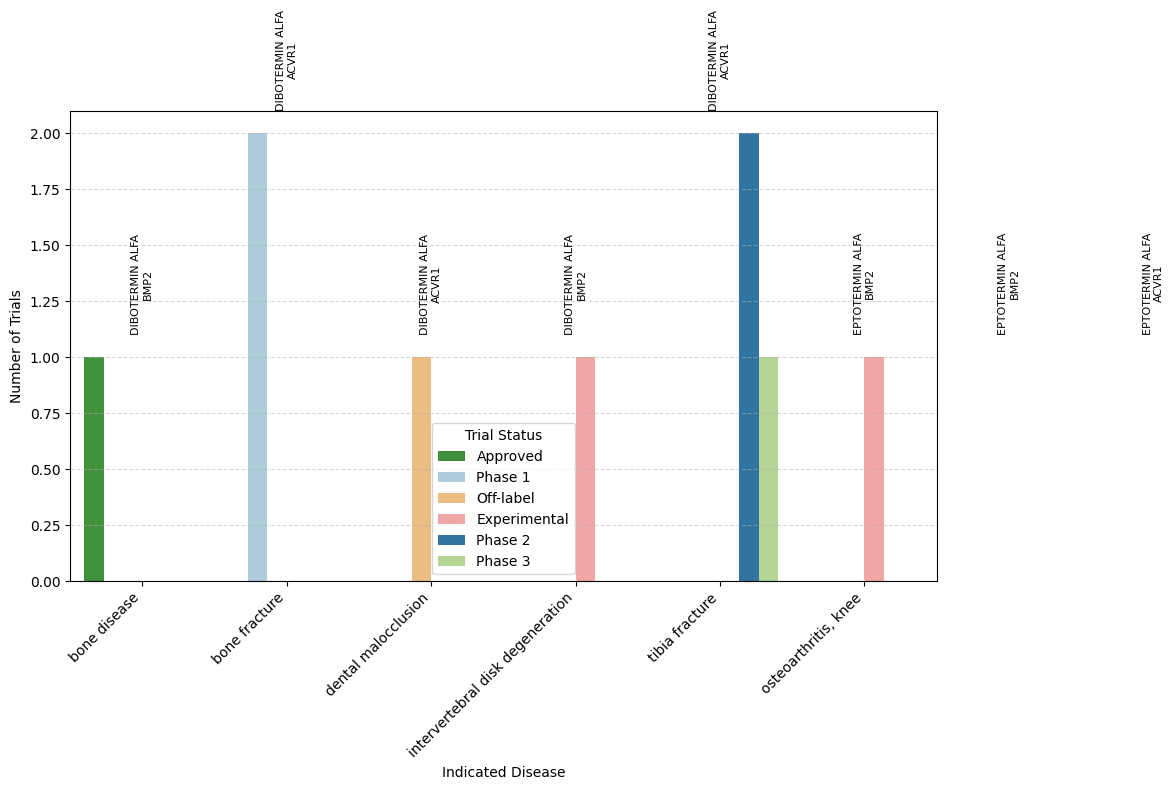

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input data
data = {
    "Drug": [
        "EPTOTERMIN ALFA", "DIBOTERMIN ALFA", "DIBOTERMIN ALFA",
        "EPTOTERMIN ALFA", "DIBOTERMIN ALFA", "DIBOTERMIN ALFA",
        "DIBOTERMIN ALFA", "DIBOTERMIN ALFA", "EPTOTERMIN ALFA",
        "DIBOTERMIN ALFA"
    ],
    "Indicated Disease": [
        "tibia fracture", "tibia fracture", "tibia fracture",
        "bone disease", "bone disease", "intervertebral disk degeneration",
        "bone fracture", "bone fracture", "osteoarthritis, knee",
        "dental malocclusion"
    ],
    "Target Gene": [
        "ACVR1", "ACVR1", "ACVR1", "BMP2", "BMP2", "BMP2",
        "ACVR1", "ACVR1", "BMP2", "ACVR1"
    ],
    "Trial Status": [
        "Phase 3", "Phase 2", "Phase 2",
        "Approved", "Approved", "Experimental",
        "Phase 1", "Phase 1", "Experimental",
        "Off-label"
    ]
}

df = pd.DataFrame(data)

# Aggregate counts
plot_df = df.groupby(['Drug', 'Indicated Disease', 'Trial Status', 'Target Gene']).size().reset_index(name='Count')

# Set colors for trial status
trial_palette = {
    "Phase 1": "#a6cee3",
    "Phase 2": "#1f78b4",
    "Phase 3": "#b2df8a",
    "Approved": "#33a02c",
    "Experimental": "#fb9a99",
    "Off-label": "#fdbf6f"
}

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=plot_df,
    x='Indicated Disease',
    y='Count',
    hue='Trial Status',
    palette=trial_palette,
    dodge=True
)

# Add annotations: Drug + Target Gene
for i, row in plot_df.iterrows():
    plt.text(
        x=i,
        y=row['Count'] + 0.1,
        s=f"{row['Drug']}\n{row['Target Gene']}",
        ha='center', va='bottom', fontsize=8, rotation=90
    )

# Styling
plt.ylabel("Number of Trials")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Trial Status')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [18]:
plt.savefig("drug_indication_static.png", dpi=300)


<Figure size 640x480 with 0 Axes>

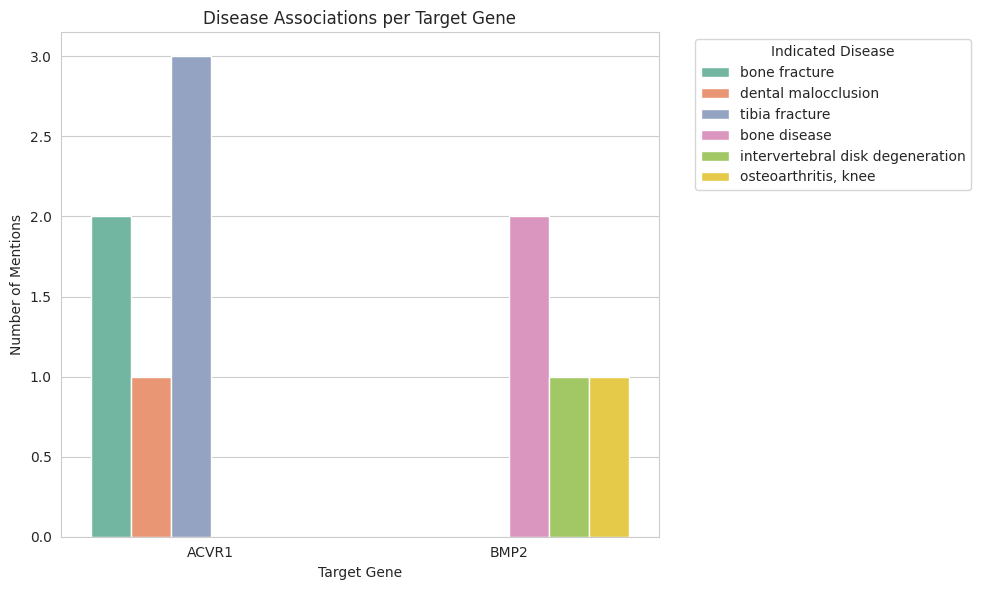

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Drug": [
        "EPTOTERMIN ALFA", "DIBOTERMIN ALFA", "DIBOTERMIN ALFA",
        "EPTOTERMIN ALFA", "DIBOTERMIN ALFA", "DIBOTERMIN ALFA",
        "DIBOTERMIN ALFA", "DIBOTERMIN ALFA", "EPTOTERMIN ALFA",
        "DIBOTERMIN ALFA"
    ],
    "Indicated Disease": [
        "tibia fracture", "tibia fracture", "tibia fracture",
        "bone disease", "bone disease", "intervertebral disk degeneration",
        "bone fracture", "bone fracture", "osteoarthritis, knee",
        "dental malocclusion"
    ],
    "Target Gene": [
        "ACVR1", "ACVR1", "ACVR1", "BMP2", "BMP2", "BMP2",
        "ACVR1", "ACVR1", "BMP2", "ACVR1"
    ],
    "Trial Status": [
        "Phase 3", "Phase 2", "Phase 2",
        "Approved", "Approved", "Experimental",
        "Phase 1", "Phase 1", "Experimental",
        "Off-label"
    ]
}

df = pd.DataFrame(data)

# Count links between Gene and Disease
count_df = df.groupby(["Target Gene", "Indicated Disease"]).size().reset_index(name="Count")

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=count_df,
    x="Target Gene",
    y="Count",
    hue="Indicated Disease",
    palette="Set2"
)

plt.title("Disease Associations per Target Gene")
plt.ylabel("Number of Mentions")
plt.xlabel("Target Gene")
plt.legend(title="Indicated Disease", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("gene_disease_barplot.png", dpi=300)
plt.show()


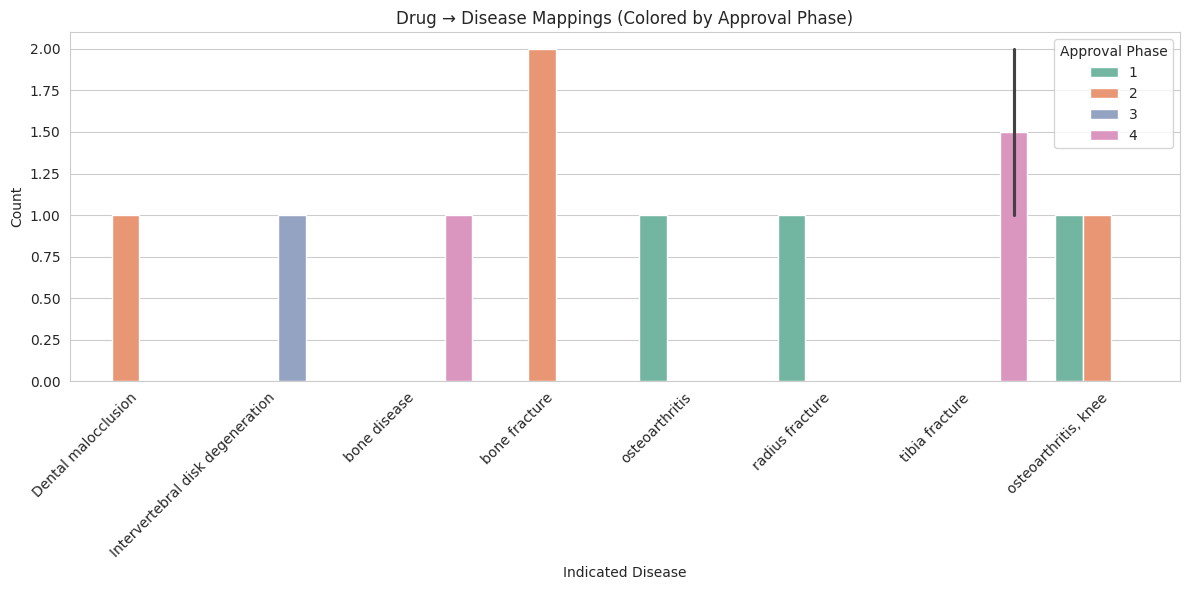

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("open_targets_drug_gene_disease.csv")

# Filter for Dibotermin and Eptotermin alfa
df_filtered = df[df['Drug'].isin(['DIBOTERMIN ALFA', 'EPTOTERMIN ALFA'])]

# Prepare data for plotting
grouped = df_filtered.groupby(['Drug', 'Indicated Disease', 'Approval Phase']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x='Indicated Disease',
    y='Count',
    hue='Approval Phase',
    palette='Set2'
)
plt.title('Drug → Disease Mappings (Colored by Approval Phase)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [24]:
pip install graphviz


In [25]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(format='png')
dot.attr(rankdir='LR', size='10')

# Nodes: Genes
dot.node('ACVR1', 'Gene: ACVR1')
dot.node('BMP2', 'Gene: BMP2')

# Nodes: Drugs
dot.node('DIB', 'Drug: Dibotermin alfa')
dot.node('EPT', 'Drug: Eptotermin alfa')

# Nodes: Mechanisms
dot.node('Mech', 'Mechanism: BMP Pathway Activation')

# Nodes: Primary Indication
dot.node('FOP', 'Disease: FOP (Fibrodysplasia Ossificans Progressiva)')

# Nodes: Repurposing Candidates
repurposed_diseases = [
    ('OA', 'Osteoarthritis'),
    ('Fx', 'Bone Fracture Healing'),
    ('SF', 'Spinal Fusion'),
    ('BD', 'Bone Defect Repair'),
]

# Add connections
dot.edge('BMP2', 'DIB')
dot.edge('BMP2', 'EPT')
dot.edge('ACVR1', 'Mech')
dot.edge('DIB', 'Mech')
dot.edge('EPT', 'Mech')
dot.edge('Mech', 'FOP')

# Repurposing paths
for code, label in repurposed_diseases:
    dot.node(code, f'Repurposing: {label}')
    dot.edge('Mech', code)

# Render to file
dot.render('dibotermin_repurposing_flowchart', view=True)


'dibotermin_repurposing_flowchart.png'

In [26]:
files.download("dibotermin_repurposing_flowchart.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>